# Multi label classifier

This classifier allows to display more than 1 label per image as well as none.
We will address the problems created by the multi label classifier such 

- voting mechanism using thresholds
- using BinaryCrossEntropy loss instead of CrossEntropy
- calculating accuracy by using a threshold


In [1]:
!pip install -q fastbook
from fastbook import *

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test')]

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Contains the Segmentation bounding box, but in the format of an image
# We could possibly train the image inputs to output a segmentation bounding box with this approach
(path/'segmentation').ls()

(#422) [Path('/root/.fastai/data/pascal_2007/segmentation/002470.png'),Path('/root/.fastai/data/pascal_2007/segmentation/009245.png'),Path('/root/.fastai/data/pascal_2007/segmentation/007480.png'),Path('/root/.fastai/data/pascal_2007/segmentation/009724.png'),Path('/root/.fastai/data/pascal_2007/segmentation/001289.png'),Path('/root/.fastai/data/pascal_2007/segmentation/003872.png'),Path('/root/.fastai/data/pascal_2007/segmentation/004009.png'),Path('/root/.fastai/data/pascal_2007/segmentation/004649.png'),Path('/root/.fastai/data/pascal_2007/segmentation/007902.png'),Path('/root/.fastai/data/pascal_2007/segmentation/007477.png')...]

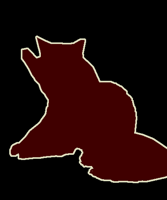

In [5]:
img = PILImage.create(path/'segmentation/002470.png')
img.to_thumb(200)

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Now that we have the data in a dataframe lets experiment with building up a DataBlock from scratch

In [7]:
db = DataBlock()
ds = db.datasets(train_df)

x,y = ds.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [8]:
# The row from the dataframe is passed as input to the get_x & get_y
db = DataBlock(get_x=lambda o: o['fname'], get_y=lambda o: o['labels'].split(' '))
ds = db.datasets(train_df)

x,y = ds.train[0]
x,y

('005620.jpg', ['aeroplane'])

In [9]:
# To be able to export the learner we can't use lambdas (They wont get serialized. Lets use a normal function)

def get_x_input(row):
    return row['fname']

def get_y_output(row):
    # Dataset shows the labels are splitted by blank space
    return row['labels'].split(' ')


db = DataBlock(get_x=get_x_input, get_y=get_y_output)
ds = db.datasets(train_df)

x,y = ds.train[0]
x,y

('002549.jpg', ['tvmonitor'])

In [10]:
# ATM the train contains as well validation data. Lets use a custom splitter to make it work

def get_validation_split(df):
    train = df.index[df['is_valid'] == False].tolist()
    valid = df.index[df['is_valid'] == True].tolist()
    return train,valid

db = DataBlock(get_x=get_x_input, get_y=get_y_output, splitter=get_validation_split)
ds = db.datasets(train_df)

x,y = ds.train[0]
x,y

('000012.jpg', ['car'])

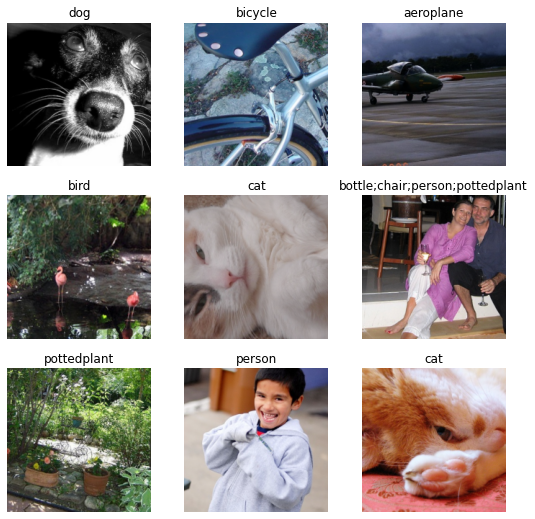

In [11]:
# Now what we are still missing is the actual Image as input.
# Lets use the real expected DataBlock for that

def get_x_input(row):
    img_name = row['fname']
    return path/'train'/img_name

db = DataBlock(
    (ImageBlock, MultiCategoryBlock),
    get_x=get_x_input,
    get_y=get_y_output,
    splitter=get_validation_split,
    item_tfms=Resize(400),
    batch_tfms=aug_transforms(size=200, min_scale=0.7)
    )
dls = db.dataloaders(train_df)

dls.show_batch()

### At this point we have the dataset ready, so we can start training a basic learner

In [12]:
learner = vision_learner(dls, models.resnet18, loss_func=nn.BCEWithLogitsLoss())
learner.fit_one_cycle(2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,0.919172,0.646623,00:19
1,0.805950,0.587218,00:18


In [13]:
# Lets inspect how this predictions & targets look like
preds,targs = learner.get_preds()
preds,targs

(TensorBase([[-0.3133,  0.2392, -2.2542,  ...,  0.7095, -0.0599,  1.7373],
             [ 0.0851, -1.0674, -2.1707,  ..., -0.6248, -1.2196, -0.4246],
             [ 0.7713,  1.0410, -3.0337,  ..., -0.6730, -0.5330,  0.2538],
             ...,
             [ 1.4510, -0.3247, -2.2470,  ..., -0.3942, -0.4956,  0.5974],
             [ 0.6860, -1.7691, -0.4427,  ..., -2.3446, -0.3595, -1.0281],
             [-1.8318,  3.0280, -1.0506,  ...,  0.0995, -1.0096, -0.3984]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]))

SuggestedLRs(valley=0.0014454397605732083)

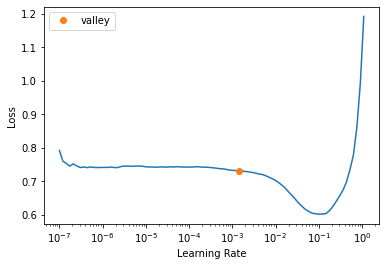

In [14]:
# Also lets take a look at the slope of our learning rates so we can train with the optimum value.
# Looking at this graph, it looks like somewhere between 0.1 & 0.01
learner.lr_find()

In [15]:
def get_multi_label_acc(p, e, threshold=0.5):
    normalized = p.sigmoid()
    return ((p > threshold) == e.bool()).float().mean()

get_multi_label_acc(preds,targs)

# Or we could just use accuracy_multi and set threshold with partial

TensorBase(0.8323)

In [75]:
# So using the better learning rate & the acc

learner = vision_learner(
    dls,
    models.resnet34,
    loss_func=nn.BCEWithLogitsLoss(),
    metrics=partial(accuracy_multi, thresh=0.5),
    lr=0.05)
learner.fine_tune(5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.907438,0.596836,0.699442,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.702887,0.501851,0.786853,00:28
1,0.582016,0.315453,0.921952,00:28
2,0.421102,0.178732,0.963347,00:28
3,0.301890,0.139451,0.967849,00:29
4,0.238818,0.135211,0.967928,00:28


Now lets take a look what kind of threshold would be the best for actual usage with the model.

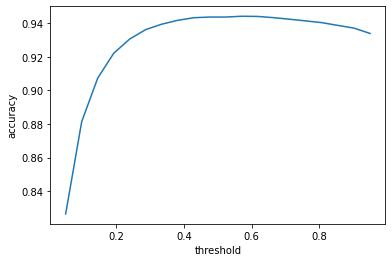

In [17]:
import matplotlib.pyplot as plt

preds,targs = learner.get_preds()

thresholds = torch.linspace(0.05,0.95,20)
accuracies = [accuracy_multi(preds, targs, thresh=i) for i in thresholds]

plt.plot(thresholds, accuracies)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

Looking at the graph, threshold 0.4-0.5 would have be best accuracy. Therefore picking something like 0.45 would be quite resonable for our predictions.
We should not try to grab one batch, and see if we can correctly guess the contents of the image.

In [18]:
dls.vocab

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


e:;person
p:;person


e:;person
p:;bicycle;car;person


e:;person
p:;bird;person


e:;car
p:;car




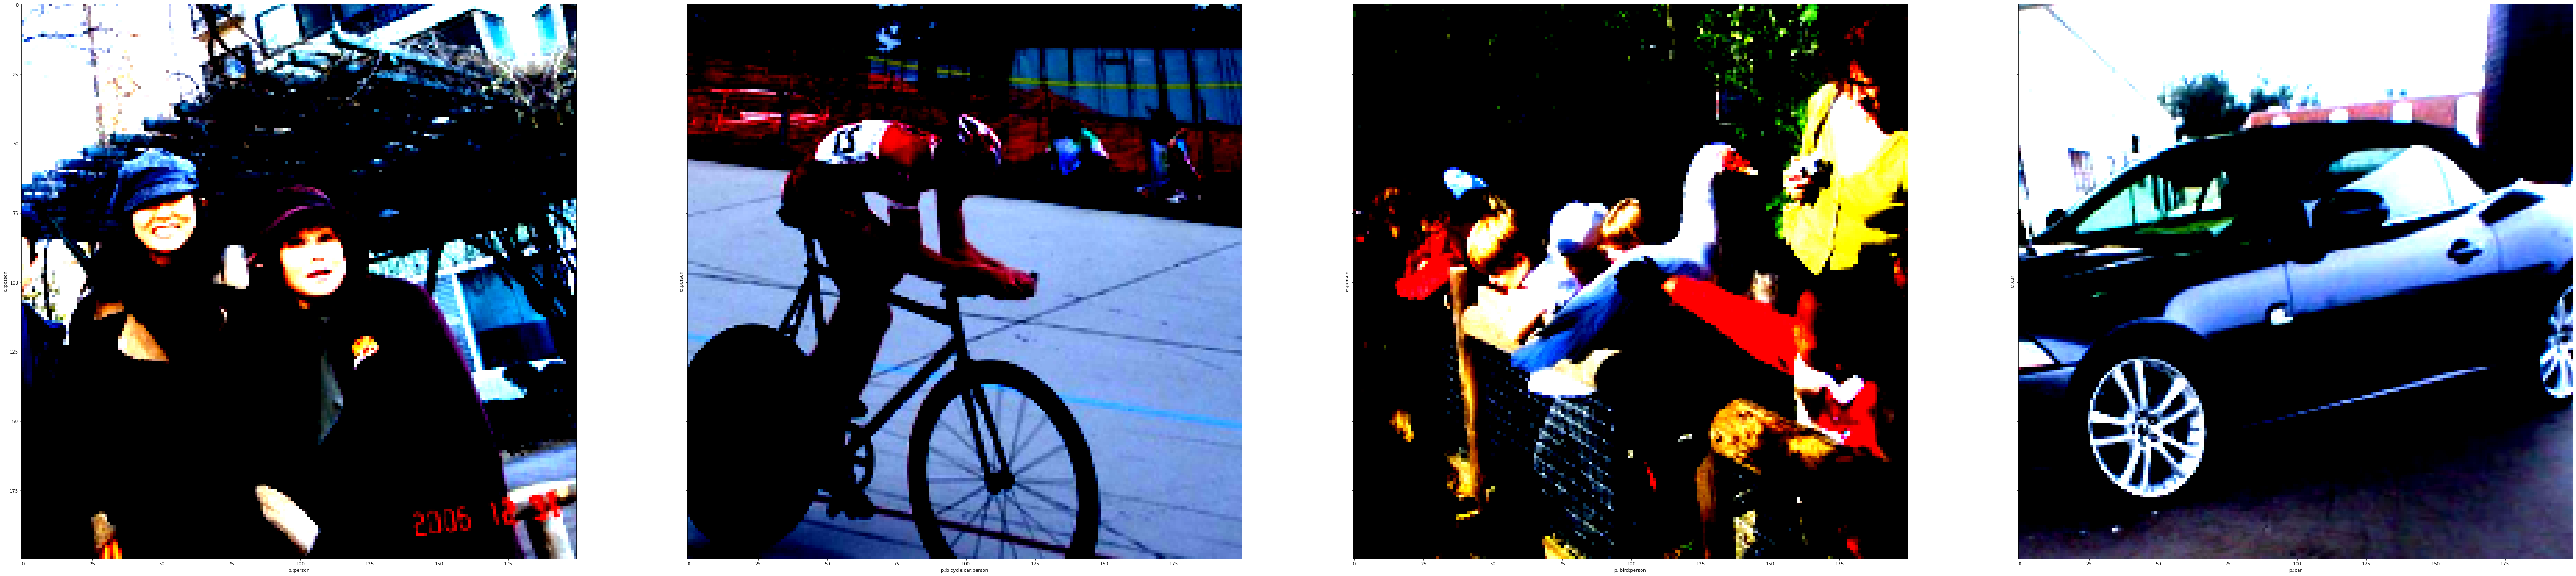

In [19]:
x,y = dls.one_batch()
# lets grab just first 4 results
top_bound = 4
x = x[:top_bound]
y = y[:top_bound]

predictions = [learner.predict(to_cpu(i)) for i in x]
# print(y)
# print(x)
# print(predictions)
fig, ax = plt.subplots(1, top_bound, sharey=True, figsize=(100, 100))

def get_labels(bools, vocab, thresh=0.5, sigmoid=False):
    expected = bools
    if sigmoid: expected= bools.sigmoid()
    final_labels = '' 
    expected = expected > thresh
    for i in range(len(expected)):
        if expected[i]:
            final_labels +=';'+vocab[i]
    return final_labels

for i in range(top_bound):
    predicted_y = predictions[i][1]
    threshold = 0.45
    print('e:'+get_labels(predicted_y, dls.vocab, sigmoid=True, thresh=threshold))
    print('p:'+get_labels(y[i], dls.vocab))
    print('\n')
    
    ax[i].imshow(to_cpu(x[i].permute(1,2,0)))
    ax[i].set_xlabel('p:'+get_labels(y[i], dls.vocab))
    ax[i].set_ylabel('e:'+get_labels(predicted_y, dls.vocab, sigmoid=True, thresh=threshold))

We can see that the predictions are not fully perfect. And there are a few things that we can do to improve the learning/evaluation.

1. Normalization. We should check what kind of normalization the resnet18 uses that we used, and use that for all our pixels
2. Test time augmentation. ATM all the validation pictures are cropped at the center, so there is smaller changce for us to capture all the nuances of the picture, and therefore having incorrect labels

The following, we won't do in the actual notebook, as it might not provide a great improvement to the pretrained network, but we should try them in the following chapters.
3. Progressive Resizing. Starting with a smaller matrix to allow the training to go faster. Althought that might be useless for the pretrained weights and better for model from scratch.
4. Mixup.
5. Label smoothing

### TTA
Lets see if we can improve the accuracy of our predictions just by having multiple Crops out of our validation data.

In [20]:
preds, targs = learner.tta()

In [21]:
'The accuracy if we use TTA is: '+ str(accuracy_multi(preds, targs, thresh=0.5).item())

'The accuracy if we use TTA is: 0.9452390670776367'

In [22]:
preds, targs = learner.get_preds()

In [23]:
'The accuracy without additional Augmentation is: '+ str(accuracy_multi(preds, targs, thresh=0.5).item())

'The accuracy without additional Augmentation is: 0.9437052011489868'

So we can see that the tta improves the accuracy a bit, although that is a diminishing result (**0.5%**) for 5times as much time taken just for inference. But for the sake of experiment lets see how we could do it on prediction?
`Learner.predict` by default creates a new test_dl just with the item that is provided. That means that we should be able to do that ourselves aswell.

Create a new DL just for the prediction, then run the `tta(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):` `dl` with the newly created value.

In [24]:
df_predict = pd.read_csv(path/'train.csv')
df_predict[~df_predict['is_valid']].head(20)

,fname,labels,is_valid
3,000012.jpg,car,False
5,000017.jpg,person horse,False
9,000023.jpg,bicycle person,False
11,000026.jpg,car,False
13,000032.jpg,aeroplane person,False
14,000033.jpg,aeroplane,False
15,000034.jpg,train,False
16,000035.jpg,person diningtable,False
17,000036.jpg,dog,False
20,000042.jpg,train,False


In [25]:
inps = learner.dls.train.one_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

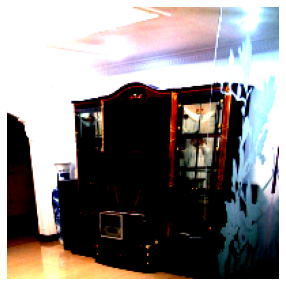

In [71]:
inps[0][1].show()

In [64]:
inps[0][0].mean(dim=[1,2])

TensorImage([-0.4402, -0.6425, -0.3575], device='cuda:0')

In [27]:
import torchvision.transforms as transforms

img = Image.open(path/'train/000073.jpg')
transform = transforms.ToTensor()
item = TensorImage(transform(img))
item = item.to(device='cuda:0')
item.shape

torch.Size([3, 500, 375])

In [28]:
item.device

device(type='cuda', index=0)

In [38]:
# we now need to generate multiple transforms of the same image. So Crop to 200*200 but from different locations
# To get easily five crops of the same image use https://pytorch.org/vision/main/auto_examples/plot_transforms.html#fivecrop from pytorch transforms

fiveCrop = transforms.FiveCrop(size= (200,200)) ## Should crop to 224 to be resnet compatible
fiveCutouts = [i for i in fiveCrop(item)]
torchCutouts = torch.stack(fiveCutouts)

In [40]:
torchCutouts.shape

torch.Size([5, 3, 200, 200])

In [43]:
normalizer = Normalize.from_stats(*imagenet_stats)
encodedCutouts = normalizer.encodes(torchCutouts)

<AxesSubplot:>

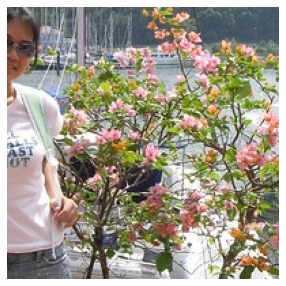

In [45]:
fiveCutouts[4].show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

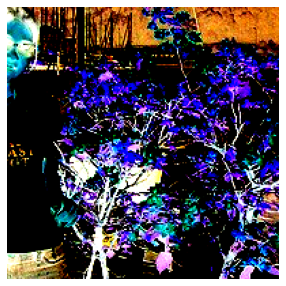

In [81]:
(encodedCutouts[4] * -1).show()

In [46]:
fiveCutouts[4].mean(dim=[1,2])

TensorImage([0.5859, 0.5609, 0.4948], device='cuda:0')

In [83]:
(normalized_cutouts[4]*(-1)).mean(dim=[1,2])

TensorImage([-0.4408, -0.4683, -0.3945], device='cuda:0')

In [79]:
learner.predict(to_cpu(inps[0][1]))[1].sigmoid() > 0.3

TensorBase([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True])

In [88]:
prede = torch.stack([learner.predict(to_cpu(i*(-1)))[1] for i in normalized_cutouts])
prede = prede.mean(dim=0)
predictions_passing_threshold = prede.sigmoid() > 0.3
predictions_passing_threshold

TensorBase([False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True,  True, False, False, False, False])

In [36]:
vocab = [i for i in dls.vocab]

In [89]:
result = ''
for i in range(len(vocab)):
    if predictions_passing_threshold[i]:
        result=result+vocab[i]
result

'personpottedplant'

### Learnings from doing the TTA for inference myself?

- Make sure that that you are using the same Normalization parameters as the pretrained model. E.g. in resnet its around ~0.4 mean, and ~0.3 std
- Make sure that the data that was used for training has the same format as yours. E.g. It could be Negated. This can be easily checked by running the mean(dim=[1,2]) (doing the dim 1,2 groups the width/height, but keeps the color chanels) on the data. This way I discovered that the data I was passing inside had a wrong format compared to the data that was used for training.
- Its always important to check what dimensions are used for the grouping. E.g. default Normalization in fastAI groups by the [0,2,3], so it can transform all batches at the same time.